In [25]:
import sys
from pathlib import Path
sys.path.append(str(Path('../..') / 'cajal'))
sys.path.append(str(Path('..') / 'simulators'))

#simulators/python/pulses/pulse_definitions.py
from python.pulses import PulseRamp

In [1]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import tensorflow as tf

from online_neuro.bayessian_optimizer import AskTellOptimizerHistory
from online_neuro.online_learning import build_model
from online_neuro.utils import CustomMinMaxScaler

from trieste.data import Dataset
from trieste.acquisition.function import BayesianActiveLearningByDisagreement
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste import space

from cajal.nrn import Backend as N
from cajal.nrn.cells import MRG
from cajal.units import mm, um, mV, ms
from cajal.nrn.sources import IsotropicPoint
from cajal.units import mA, ms, ohm, cm, um
from cajal.nrn.monitors import StateMonitor, APMonitor
from cajal.nrn import SimulationEnvironment

from neuron import h
from cajal.nrn.stimuli import MonophasicPulse
from simulators.python.pulses import PulseRamp

2025-01-24 09:47:58.719067: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 09:47:58.725598: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-24 09:47:58.784469: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-24 09:47:58.909545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-24 09:47:59.059354: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

numprocs=1


In [2]:
# Set-up time resolution
N.dt = 0.005*ms #The default one

In [3]:
def create_mrg(diameter: um=27, length: mm=100, v_init: mV=-80, verbose=False):
    # Create the axon model (MRG) with specified diameter, length, and initial voltage
    mrg = MRG(diameter=diameter, length=length, v_init=v_init)

    # If verbose mode is enabled, output detailed information about the axon
    if verbose:
        # Print the total number of nodes in the axon
        print(f"Computed number of Nodes: {len(mrg.node)}")

        # Calculate and print the total axon length based on the first and last node positions
        first_node_y = mrg.node[0].y3d(0)
        last_node_y = mrg.node[-1].y3d(0)
        total_length = (last_node_y - first_node_y) / 1000
        print(f"Computed Axon Length: {total_length:.2f} mm")

        # Print the 3D coordinates of the first and last nodes
        for node, node_name in zip([mrg.node[0], mrg.node[-1]], ['first', 'last']):
            x = node.x3d(0) / 1000  # Convert from um to mm
            y = node.y3d(0) / 1000
            z = node.z3d(0) / 1000
            print(f"Node position of the {node_name} node in the axon: x={x:.2f} mm, y={y:.2f} mm, z={z:.2f} mm")

    return mrg

def plot_setup(mrg, point_sources, labels=None):
    # Extract 3D coordinates of axon nodes and convert from um to mm
    node_x = np.array([n.x3d(0) for n in mrg.node]) / 1000.0
    node_y = np.array([n.y3d(0) for n in mrg.node]) / 1000.0
    node_z = np.array([n.z3d(0) for n in mrg.node]) / 1000.0

    # Set up the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the axon as a red line in 3D space
    ax.plot(node_x, node_y, node_z, color='red', label='Axon (MRG)', linewidth=2)

    # Plot each electrode as a green marker in 3D space
    for e, point_source in enumerate(point_sources):
        x = point_source.x.value / 1000.0  # Convert from um to mm
        y = point_source.y.value / 1000.0
        z = point_source.z.value / 1000.0

        # Use provided labels or default to "Electrode"
        label = labels[e] if labels else "Electrode"
        if label == 'Stim':
            ax.scatter(x, y, z, color='green', s=80, marker='o', label=label)
        else:
            ax.scatter(x, y, z, color='red', s=80, marker='^', label=label)

    # Add axis labels
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')

    # Adjust the viewing angle for better visualization
    ax.view_init(elev=20, azim=30)

    # Add a title and legend, and show the plot
    plt.title('Axon and Two Electrodes in 3D')
    plt.legend()
    plt.show()


In [4]:
from simulators.python.problems.cajal_problems import create_stimulus, create_pulse
from simulators.python.pulses import PulseRamp

mrg = create_mrg(diameter=27, length=100, v_init=-80, verbose=True)
stim_amp = -1.00 #* mA
stim_pw = 0.50 #* ms
stim_delay = 2.5 #* ms
stim = create_pulse('monophasic', amp=stim_amp, pw=stim_pw, delay=stim_delay)

block = PulseRamp( delay=0.5, amplitude=0.8, pulse_width=0.50,
                    interphase_gap=1, decay_width=2, k=1, ramp_width=1, # k =1  linear decay
                    tau=1, offset=0)

# Create electrodes at both sides of origin (spacing 20 mm) and 1 mm above the nerve
pointsource_stim = IsotropicPoint(x=0 * mm, y=-10 * mm, z=1 * mm, rhoe=500 * ohm * cm)
pointsource_block = IsotropicPoint(x=0 * mm, y=10 * mm, z=1 * mm, rhoe=500 * ohm * cm)

# Assign stimuli to electrodes
electrode_stim = pointsource_stim << stim
electrode_block = pointsource_block << block

# Set up monitors not at the complete edges to avoid boundary conditions
ap_monitor_end = APMonitor(mrg.node[-10], threshold= -20 * mV)
ap_monitor_start = APMonitor(mrg.node[10], threshold= -20 * mV)
v_rec = StateMonitor(mrg.node, "v")

Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm


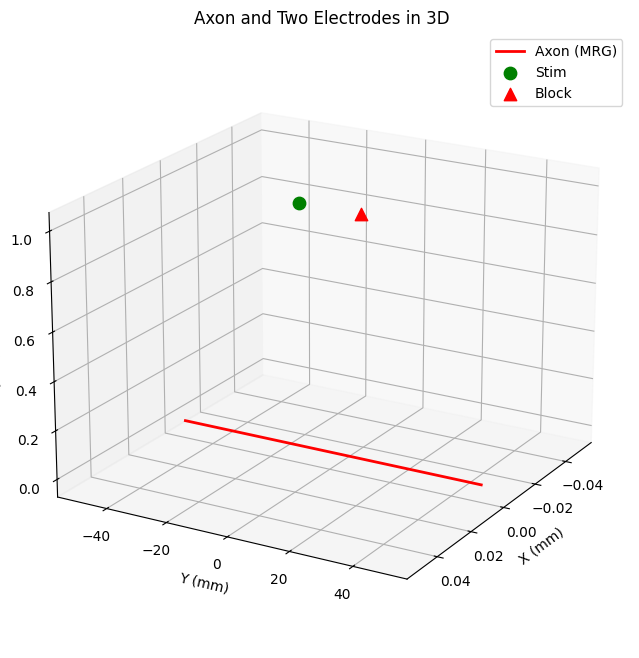

In [5]:
pointsources = [pointsource_stim, pointsource_block]
labels = ['Stim','Block']
plot_setup(mrg, pointsources, labels)

In [6]:
def plot_progression_AP_3D(mrg, v_rec):
    V = v_rec.v
    t = v_rec.t  # This gives you all time points recorded

    # Convert time to ms for plotting
    T = t / ms

    # Create meshgrids for node numbers and time steps
    nodes = np.arange(mrg.axonnodes)
    T_2D, N_2D = np.meshgrid(T, nodes, indexing='ij')  # shape (#time_steps, #nodes)
    V_t = V.T

    # Define desired membrane potential limits
    vmin = -120
    vmax = 70

    # Create a 3D figure
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(N_2D, T_2D, V_t, cmap='jet', edgecolor='none', alpha=0.8,
                           vmin=vmin, vmax=vmax)

    ax.set_zlim(vmin, vmax)
    ax.set_xlabel('Node Number')
    ax.set_ylabel('Time (ms)')
    ax.set_zlabel('Membrane Potential (mV)')
    ax.set_title('AP Progression')

    fig.colorbar(surf, shrink=0.5, aspect=10, label='Membrane Potential (mV)')

    plt.tight_layout()
    plt.show()

In [7]:
# Create the simulation environment
env = SimulationEnvironment(
    axons=[mrg],
    extra_stim=[electrode_stim,
                electrode_block],
    monitors=[
        v_rec,
        ap_monitor_end,
        ap_monitor_start]
)

# Run the simulation for a sufficient duration to observe AP propagation
env.run(runtime = 6 * ms, progressbar=True, early_stopping=False)


5.5 ms: 100%|██████████| 1200/1200 [00:07<00:00, 158.45it/s]



Simulation Environment:
  # axons: 1
  # extracellular stimulating electrodes: 2
  dt: 0.005 ms

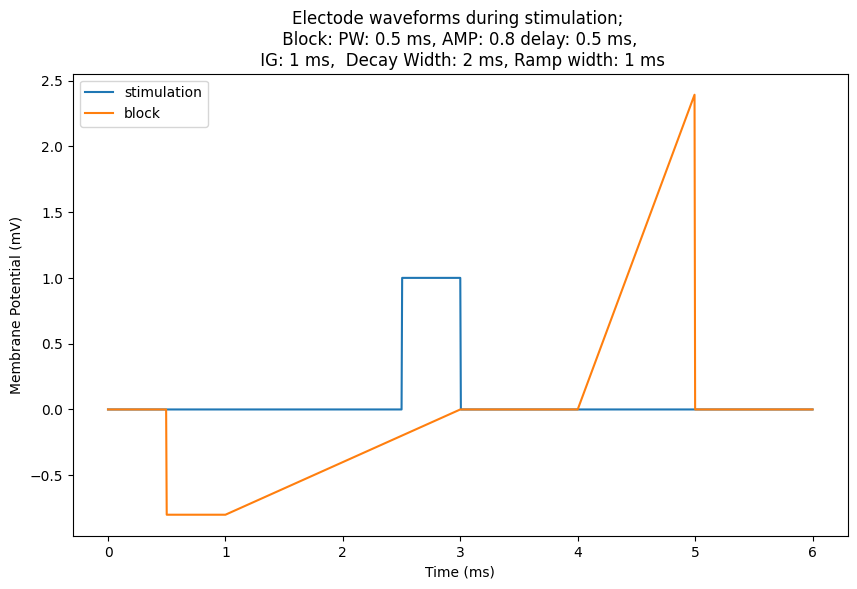

In [8]:
def plot_stim_and_block(stim, block, v_rec):  
    fig = plt.figure(figsize=(10, 6))
    t= v_rec.t 
    T = t / ms # time axes (X-as)

    delay = block.interphase_gap

    plt.plot(T, -np.asarray(stim(t=v_rec.t)), label='stimulation')
    plt.plot(T, -np.asarray(block(t=v_rec.t)), label='block')
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.title(f'Electode waveforms during stimulation; \n Block: PW: {block.pw}, AMP: {block.amp}' 
              f' delay: {block.delay}, \n IG: {block.interphase_gap},  Decay Width: {block.decay_width}, Ramp width: {block.ramp_width}')
    plt.legend(loc="upper left")

    plt.show()

plot_stim_and_block(stim, block, v_rec)

In [9]:
# If you want interactive plots
%matplotlib ipympl

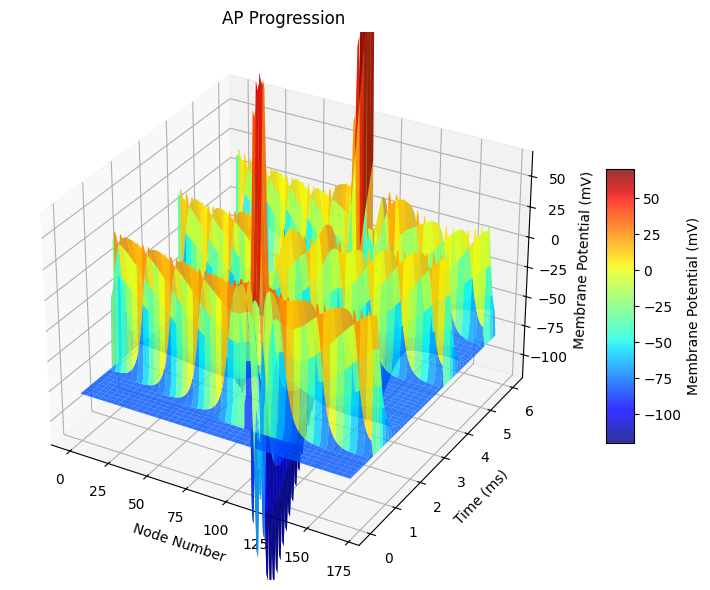

In [9]:
plot_progression_AP_3D(mrg, v_rec)

## Now performing the optimisation with online-neuro

In [19]:
def nerve_block_condition(ap_monitor_left, ap_monitor_right):

    ap_count_right = ap_monitor_right.n(t=0 * ms)
    # print(f"Number of APs after 2.50 ms at end node: {ap_count_end}")

    start_time = 2.4 * ms
    end_time = 4.0 * ms

    # Calculate the number of APs between start_time and end_time at the start node
    ap_count_left_end = ap_monitor_left.n(t=end_time)
    ap_count_left_start = ap_monitor_left.n(t=start_time)
    ap_count_left = ap_count_left_start - ap_count_left_end # Never less than zero
    print(f"Number of APs between {start_time} and {end_time} ms at start node: {ap_count_left}")

    ap_times_end = ap_monitor_right.spikes()
    print(f"All spike times at end node: {ap_times_end}")
    
    if ap_count_right > 0:
        print("There is an AP on the right side")
        return 1
    else:
        if ap_count_left == 0:
            print('NO AP at the left side')
            return 1
        else:
            print("AP IS BLOCKED!!!")
            return 0
        

def nerve_block_condition_2(ap_monitor_left, ap_monitor_right):
    # Allow AP at the right side in the beginning
    ap_count_right = ap_monitor_right.n(t=2.2 * ms)

    # Check if there is an AP on the left side between specific interval
    start_time = 3.4 * ms
    end_time = 4.0 * ms

    # Calculate the number of APs between start_time and end_time at the start node
    ap_count_left_end = ap_monitor_left.n(t=end_time)
    ap_count_left_start = ap_monitor_left.n(t=start_time)
    ap_count_left = ap_count_left_start - ap_count_left_end # Never less than zero
    print(f"Number of APs between {start_time} and {end_time} ms at the left side: {ap_count_left}")

    ap_times_end = ap_monitor_right.spikes()
    print(f"All spike times at the right side: {ap_times_end}")
    
    if ap_count_right > 0:
        print("There is more than 1 AP on the right side")
        return 1
    else:
        if ap_count_left == 0:
            print('NO AP at the left side')
            return 1
        else:
            print("AP IS BLOCKED!!!")
            return 0

def nerve_block_condition_3(ap_monitor_left, ap_monitor_right):
    # Check if there is an AP on the left side between specific interval
    start_time = 2.6 * ms
    end_time = 4.0 * ms

    # Calculate the number of APs between start_time and end_time at the start left side
    ap_count_left_end = ap_monitor_left.n(t=end_time)
    ap_count_left_start = ap_monitor_left.n(t=start_time)
    ap_count_left = ap_count_left_start - ap_count_left_end # Never less than zero
    print(f"Number of APs between {start_time} and {end_time} ms at the left side: {ap_count_left}")

    # Allow AP at the right side but not in the interval of the test pulse
    # Calculate the number of APs between start_time and end_time at the start right side
    ap_count_right_end = ap_monitor_right.n(t=end_time)
    ap_count_right_start = ap_monitor_right.n(t=start_time)
    ap_count_right = ap_count_right_start - ap_count_right_end

    ap_times_end = ap_monitor_right.spikes()
    print(f"All spike times at the right side: {ap_times_end}")
    
    if ap_count_right > 0:
        print("There is AP on the right side")
        return 1
    else:
        if ap_count_left == 0:
            print('NO AP at the left side')
            return 1
        else:
            print("AP IS BLOCKED!!!")
            return 0



def run_simulation(mrg, block_amp, block_pw, block_delay,  block_ig,  block_decay_width,  block_ramp_width):
    """
    Run the AP blocking simulation with given stimulus parameters.
    
    Parameters:
    - stim_amp_end: Amplitude of the second stimulus (mA)
    - stim_delay_end: Delay of the second stimulus (ms)
    
    Returns:
    - ap_count: Number of action potentials reaching the end of the axon.
    """

    print(f"Configuration: Amplitude {block_amp:.2f} mA, pulse width {block_pw:.2f} ms, delay {block_delay:.2f}" + 
          f" IG {block_ig:.2f}, decay width (first) {block_decay_width:.2f}, ramp_width (second) {block_ramp_width:.2f}")

    # Setup a default (fixed) stimulation values 
    stim_amp = -0.20 #* mA
    stim_pw = 0.05 #* ms
    stim_delay = 2.5 #* ms

    # Create stimuli
    stim = create_pulse('monophasic', amp=stim_amp, pw=stim_pw, delay=stim_delay)

    block = PulseRamp(delay=block_delay, amplitude=block_amp, pulse_width=block_pw,
                    interphase_gap=block_ig, decay_width=block_decay_width, k=1, ramp_width=block_ramp_width, # k =1  linear decay
                    tau=1, offset=0)

    # Create electrodes at both ends (set spacing of 20 mm)
    pointsource_stim = IsotropicPoint(x=0 * mm, y=-20 * mm, z=1 * mm, rhoe=500 * ohm * cm)
    pointsource_block = IsotropicPoint(x=0 * mm, y=20 * mm, z=1 * mm, rhoe=500 * ohm * cm)

    # Assign stimuli to electrodes
    electrode_stim = pointsource_stim << stim
    electrode_block = pointsource_block << block

    # Set up monitors
    ap_monitor_end = APMonitor(mrg.node[-5], threshold= -20 * mV)
    ap_monitor_start = APMonitor(mrg.node[5], threshold= -20 * mV)
    v_rec = StateMonitor(mrg.node, "v")

    # Create the simulation environment
    env = SimulationEnvironment(
        axons=[mrg],
        extra_stim=[electrode_stim, electrode_block],
        monitors=[v_rec, ap_monitor_end, ap_monitor_start]
    )

    # Run the simulation for a sufficient duration to observe AP propagation
    env.run(6 * ms, early_stopping=False)

    return nerve_block_condition(ap_monitor_start, ap_monitor_end)

In [20]:
def nerve_conduction_blocking_objective(params):
    """
    Objective function to optimize AP blocking
    """
    # Set desired diameter, length and v_init
    mrg = create_mrg(diameter=27, length=100, v_init=-80, verbose=True)
    
    block_amp, block_pw, block_delay, ig, decay_width, ramp_width = params[:, 0], params[:, 1], params[:, 2], params[:, 3], params[:, 4], params[:, 5]
    
    observations = []
    
    for amp, pw, delay,ig, decay_width, ramp_width in zip(block_amp, block_pw, block_delay, ig, decay_width, ramp_width):
        # Run the simulation with given parameters
        try:
            # Run the simulation and get the AP observation
            ap_count = run_simulation(mrg, amp, pw, delay, ig, decay_width, ramp_width)
            observations.append(ap_count)

        except Exception as e:
            print(f"Simulation failed with amp={amp}, pulse width={pw}, delay={delay}: {e}")
            observations.append(np.nan)  

    return np.array(observations).reshape(-1, 1)


In [21]:
# Define parameter bounds
lb = [-5.0, 0.05, 0.10, 0.05, 0.05, 0.05]  # Lower bounds for [amp, pw, delay, ig, decay_width, ramp_width]
ub = [5.0, 4.50, 1.50, 1, 1.5, 1.5]  # Upper bounds

# Initialize scaler
scaler = CustomMinMaxScaler(feature_min=lb, feature_max=ub, output_range=(-1, 1))

# Define search space
search_space = space.Box(lower=[-1, -1, -1], upper=[1, 1, 1])
search_space = space.Box(lower=np.full(len(lb),-1, float), upper=np.full(len(lb),1, float))

# Generate initial samples
init_samples = 40
qp_minmax = search_space.sample(init_samples).numpy()
qp = scaler.inverse_transform(qp_minmax)

observations = nerve_conduction_blocking_objective(qp)

Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm
Configuration: Amplitude 4.44 mA, pulse width 2.99 ms, delay 1.14 IG 0.37, decay width (first) 0.38, ramp_width (second) 0.49


5.5 ms: 100%|██████████| 1200/1200 [00:37<00:00, 32.08it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [1.33 5.88]
There is an AP on the right side
Configuration: Amplitude 3.21 mA, pulse width 3.25 ms, delay 0.74 IG 0.47, decay width (first) 0.27, ramp_width (second) 0.35


5.5 ms: 100%|██████████| 1200/1200 [00:46<00:00, 25.95it/s]
2025-01-24 10:27:25,966 rank[0] [INFO] The pulse ends after the simulation end time.


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [0.945 2.655 5.64 ]
There is an AP on the right side
Configuration: Amplitude -3.41 mA, pulse width 4.28 ms, delay 1.36 IG 0.29, decay width (first) 1.41, ramp_width (second) 0.83


5.5 ms: 100%|██████████| 1200/1200 [00:39<00:00, 30.41it/s]
2025-01-24 10:28:05,890 rank[0] [INFO] The pulse ends after the simulation end time.


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: []
AP IS BLOCKED!!!
Configuration: Amplitude 4.63 mA, pulse width 3.86 ms, delay 1.04 IG 0.36, decay width (first) 1.32, ramp_width (second) 0.56


5.5 ms: 100%|██████████| 1200/1200 [00:34<00:00, 34.50it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [1.23]
There is an AP on the right side
Configuration: Amplitude -4.70 mA, pulse width 0.97 ms, delay 1.46 IG 0.67, decay width (first) 1.23, ramp_width (second) 0.26


5.5 ms: 100%|██████████| 1200/1200 [00:38<00:00, 31.47it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [3.805 5.19 ]
There is an AP on the right side
Configuration: Amplitude -3.67 mA, pulse width 0.64 ms, delay 0.37 IG 0.59, decay width (first) 1.48, ramp_width (second) 0.43


5.5 ms: 100%|██████████| 1200/1200 [00:34<00:00, 34.35it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [3.385]
There is an AP on the right side
Configuration: Amplitude -2.70 mA, pulse width 2.53 ms, delay 1.42 IG 0.36, decay width (first) 1.38, ramp_width (second) 0.22


5.5 ms: 100%|██████████| 1200/1200 [00:32<00:00, 36.74it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: []
AP IS BLOCKED!!!
Configuration: Amplitude -4.12 mA, pulse width 3.25 ms, delay 0.76 IG 0.51, decay width (first) 0.43, ramp_width (second) 1.02


5.5 ms: 100%|██████████| 1200/1200 [00:30<00:00, 39.17it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: []
AP IS BLOCKED!!!
Configuration: Amplitude 3.99 mA, pulse width 0.19 ms, delay 1.29 IG 0.24, decay width (first) 1.26, ramp_width (second) 1.33


5.5 ms: 100%|██████████| 1200/1200 [00:25<00:00, 47.59it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 0
All spike times at end node: [1.48  3.665 4.73 ]
There is an AP on the right side
Configuration: Amplitude 3.47 mA, pulse width 0.91 ms, delay 1.07 IG 0.99, decay width (first) 0.74, ramp_width (second) 0.36


5.5 ms: 100%|██████████| 1200/1200 [00:23<00:00, 51.40it/s]
2025-01-24 10:31:48,106 rank[0] [INFO] The pulse ends after the simulation end time.


Number of APs between 2.4 ms and 4.0 ms ms at start node: 0
All spike times at end node: [1.27 4.54]
There is an AP on the right side
Configuration: Amplitude -4.88 mA, pulse width 3.71 ms, delay 0.25 IG 0.94, decay width (first) 1.25, ramp_width (second) 0.16


5.5 ms: 100%|██████████| 1200/1200 [00:27<00:00, 43.06it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: []
AP IS BLOCKED!!!
Configuration: Amplitude 0.04 mA, pulse width 0.73 ms, delay 0.46 IG 0.87, decay width (first) 1.11, ramp_width (second) 1.45


5.5 ms: 100%|██████████| 1200/1200 [00:28<00:00, 41.63it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [3.315]
There is an AP on the right side
Configuration: Amplitude 4.42 mA, pulse width 0.78 ms, delay 1.40 IG 0.99, decay width (first) 0.21, ramp_width (second) 0.61


5.5 ms: 100%|██████████| 1200/1200 [00:29<00:00, 40.94it/s]
2025-01-24 10:33:14,918 rank[0] [INFO] The pulse ends after the simulation end time.


Number of APs between 2.4 ms and 4.0 ms ms at start node: 0
All spike times at end node: [1.59 4.38]
There is an AP on the right side
Configuration: Amplitude -0.56 mA, pulse width 2.42 ms, delay 1.07 IG 0.66, decay width (first) 1.08, ramp_width (second) 0.84


5.5 ms: 100%|██████████| 1200/1200 [00:29<00:00, 41.11it/s]
2025-01-24 10:33:44,288 rank[0] [INFO] The pulse ends after the simulation end time.


Number of APs between 2.4 ms and 4.0 ms ms at start node: 0
All spike times at end node: [1.485]
There is an AP on the right side
Configuration: Amplitude 3.77 mA, pulse width 2.70 ms, delay 1.49 IG 0.25, decay width (first) 0.87, ramp_width (second) 1.17


5.5 ms: 100%|██████████| 1200/1200 [00:30<00:00, 39.13it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 0
All spike times at end node: [1.69]
There is an AP on the right side
Configuration: Amplitude 4.33 mA, pulse width 2.84 ms, delay 0.12 IG 0.98, decay width (first) 0.40, ramp_width (second) 0.77


5.5 ms: 100%|██████████| 1200/1200 [00:35<00:00, 33.47it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [0.305 5.57 ]
There is an AP on the right side
Configuration: Amplitude -0.02 mA, pulse width 1.90 ms, delay 0.78 IG 0.36, decay width (first) 0.47, ramp_width (second) 0.25


5.5 ms: 100%|██████████| 1200/1200 [00:27<00:00, 44.20it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [3.315]
There is an AP on the right side
Configuration: Amplitude 3.54 mA, pulse width 0.30 ms, delay 1.05 IG 0.38, decay width (first) 1.06, ramp_width (second) 0.19


5.5 ms: 100%|██████████| 1200/1200 [00:29<00:00, 40.06it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 0
All spike times at end node: [1.25]
There is an AP on the right side
Configuration: Amplitude -0.55 mA, pulse width 0.98 ms, delay 0.52 IG 0.22, decay width (first) 0.29, ramp_width (second) 0.91


5.5 ms: 100%|██████████| 1200/1200 [00:27<00:00, 44.08it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 0
All spike times at end node: [0.935]
There is an AP on the right side
Configuration: Amplitude -4.95 mA, pulse width 3.34 ms, delay 0.47 IG 0.22, decay width (first) 0.10, ramp_width (second) 0.32


5.5 ms: 100%|██████████| 1200/1200 [00:31<00:00, 38.13it/s]
2025-01-24 10:36:47,787 rank[0] [INFO] The pulse ends after the simulation end time.


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: []
AP IS BLOCKED!!!
Configuration: Amplitude 2.20 mA, pulse width 3.59 ms, delay 1.39 IG 0.69, decay width (first) 0.97, ramp_width (second) 0.82


5.5 ms: 100%|██████████| 1200/1200 [00:32<00:00, 37.01it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 0
All spike times at end node: [1.615 3.525 5.585]
There is an AP on the right side
Configuration: Amplitude 0.90 mA, pulse width 0.83 ms, delay 0.34 IG 0.59, decay width (first) 1.04, ramp_width (second) 1.33


5.5 ms: 100%|██████████| 1200/1200 [00:30<00:00, 39.89it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [0.625 3.335 4.63 ]
There is an AP on the right side
Configuration: Amplitude -1.81 mA, pulse width 0.31 ms, delay 1.24 IG 0.80, decay width (first) 1.32, ramp_width (second) 0.55


5.5 ms: 100%|██████████| 1200/1200 [00:26<00:00, 45.69it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [2.115 4.59 ]
There is an AP on the right side
Configuration: Amplitude -3.13 mA, pulse width 2.51 ms, delay 1.43 IG 0.29, decay width (first) 1.48, ramp_width (second) 0.14


5.5 ms: 100%|██████████| 1200/1200 [00:38<00:00, 30.90it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: []
AP IS BLOCKED!!!
Configuration: Amplitude 2.00 mA, pulse width 0.33 ms, delay 0.43 IG 0.35, decay width (first) 0.58, ramp_width (second) 1.19


5.5 ms: 100%|██████████| 1200/1200 [00:27<00:00, 43.06it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [0.655 2.325 3.425]
There is an AP on the right side
Configuration: Amplitude -2.55 mA, pulse width 3.12 ms, delay 0.46 IG 0.86, decay width (first) 0.51, ramp_width (second) 0.97


5.5 ms: 100%|██████████| 1200/1200 [00:25<00:00, 47.35it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: []
AP IS BLOCKED!!!
Configuration: Amplitude 1.57 mA, pulse width 0.30 ms, delay 0.64 IG 0.33, decay width (first) 1.22, ramp_width (second) 0.52


5.5 ms: 100%|██████████| 1200/1200 [00:32<00:00, 37.37it/s]
2025-01-24 10:40:22,308 rank[0] [INFO] The pulse ends after the simulation end time.


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [0.875 3.35 ]
There is an AP on the right side
Configuration: Amplitude -1.77 mA, pulse width 3.63 ms, delay 0.88 IG 0.12, decay width (first) 0.67, ramp_width (second) 1.35


5.5 ms: 100%|██████████| 1200/1200 [00:43<00:00, 27.83it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 0
All spike times at end node: [1.88]
There is an AP on the right side
Configuration: Amplitude 2.68 mA, pulse width 2.93 ms, delay 0.84 IG 0.33, decay width (first) 0.37, ramp_width (second) 0.13


5.5 ms: 100%|██████████| 1200/1200 [00:50<00:00, 23.74it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [1.055 2.865]
There is an AP on the right side
Configuration: Amplitude -2.75 mA, pulse width 0.29 ms, delay 1.13 IG 0.44, decay width (first) 0.27, ramp_width (second) 0.53


5.5 ms: 100%|██████████| 1200/1200 [00:33<00:00, 36.18it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [1.905 3.105]
There is an AP on the right side
Configuration: Amplitude -2.78 mA, pulse width 0.93 ms, delay 0.88 IG 0.63, decay width (first) 1.17, ramp_width (second) 0.08


5.5 ms: 100%|██████████| 1200/1200 [00:32<00:00, 37.46it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [3.375 4.3  ]
There is an AP on the right side
Configuration: Amplitude -1.35 mA, pulse width 2.31 ms, delay 0.23 IG 0.07, decay width (first) 1.14, ramp_width (second) 0.41


5.5 ms: 100%|██████████| 1200/1200 [00:36<00:00, 32.45it/s]
2025-01-24 10:43:39,631 rank[0] [INFO] The pulse ends after the simulation end time.


Number of APs between 2.4 ms and 4.0 ms ms at start node: 0
All spike times at end node: [1.01 4.61]
There is an AP on the right side
Configuration: Amplitude -0.74 mA, pulse width 2.73 ms, delay 1.30 IG 0.82, decay width (first) 0.52, ramp_width (second) 0.83


5.5 ms: 100%|██████████| 1200/1200 [00:36<00:00, 32.94it/s]
2025-01-24 10:44:16,219 rank[0] [INFO] The pulse ends after the simulation end time.


Number of APs between 2.4 ms and 4.0 ms ms at start node: 0
All spike times at end node: [1.775]
There is an AP on the right side
Configuration: Amplitude 2.14 mA, pulse width 3.92 ms, delay 0.24 IG 0.36, decay width (first) 0.30, ramp_width (second) 1.29


5.5 ms: 100%|██████████| 1200/1200 [00:29<00:00, 40.19it/s]
2025-01-24 10:44:46,229 rank[0] [INFO] The pulse ends after the simulation end time.


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [0.46  2.385 4.315]
There is an AP on the right side
Configuration: Amplitude -3.11 mA, pulse width 4.38 ms, delay 0.47 IG 0.41, decay width (first) 0.62, ramp_width (second) 0.13


5.5 ms: 100%|██████████| 1200/1200 [00:40<00:00, 29.75it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: []
AP IS BLOCKED!!!
Configuration: Amplitude 2.20 mA, pulse width 2.77 ms, delay 1.02 IG 0.26, decay width (first) 0.62, ramp_width (second) 0.64


5.5 ms: 100%|██████████| 1200/1200 [00:33<00:00, 35.84it/s]
2025-01-24 10:46:00,486 rank[0] [INFO] The pulse ends after the simulation end time.


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [1.245 3.155 5.735]
There is an AP on the right side
Configuration: Amplitude 4.20 mA, pulse width 3.10 ms, delay 0.37 IG 0.64, decay width (first) 1.35, ramp_width (second) 1.46


5.5 ms: 100%|██████████| 1200/1200 [00:27<00:00, 44.18it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [0.56  3.715]
There is an AP on the right side
Configuration: Amplitude -1.82 mA, pulse width 3.91 ms, delay 0.38 IG 0.09, decay width (first) 0.88, ramp_width (second) 0.12


5.5 ms: 100%|██████████| 1200/1200 [00:31<00:00, 38.21it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 0
All spike times at end node: [1.45]
There is an AP on the right side
Configuration: Amplitude -3.67 mA, pulse width 0.15 ms, delay 0.35 IG 0.47, decay width (first) 0.80, ramp_width (second) 0.23


5.5 ms: 100%|██████████| 1200/1200 [00:38<00:00, 30.87it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [1.335 2.465]
There is an AP on the right side
Configuration: Amplitude 2.23 mA, pulse width 1.63 ms, delay 0.45 IG 0.55, decay width (first) 0.53, ramp_width (second) 1.17


5.5 ms: 100%|██████████| 1200/1200 [00:33<00:00, 35.80it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 0
All spike times at end node: [0.675 4.68 ]
There is an AP on the right side


In [22]:
# Create initial dataset (set query point in minmax)
init_dataset = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                       observations=tf.cast(observations, tf.float64))

# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp))

# Build model
model_config = {
    'classification': True,
    'variational': True,
    'sparse': False,
    'trainable_likelihood': True,
    'noise_free': True,
}

online_model = build_model(init_dataset, search_space, model_config)

# Set up acquisition function and rule
acq = BayesianActiveLearningByDisagreement()
rule = EfficientGlobalOptimization(builder=acq, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_model,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   overwrite=True,
                                   track_path='nerve_block')

2025-01-24 10:48:17.936829: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


In [23]:
# Optimization loop
max_iters = 15  # Increase the number of iterations as needed
iter = 0

while iter < max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')

    qp_minmax_new = ask_tell.ask_and_save().numpy()
    qp_new = scaler.inverse_transform(qp_minmax_new)

    #print(f"Configuration: amplitude {qp_new[-1, 0]:.2f} mA, pulse with {qp_new[-1, 1]:.2f} with delay {qp_new[-1, 2]:.2f} ms")

    # Run the simulation and get observations
    observations_new = nerve_conduction_blocking_objective(qp_new)

    if observations_new.ndim == 1:
        observations_new = observations_new.reshape(-1, 1)

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))

    # Create the new dataset
    tagged_output = Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                            observations=tf.cast(observations_new, tf.float64))
    
    # Update the optimizer with new data
    ask_tell.tell(tagged_output)
    iter += 1

# Save results
ask_tell.save()

2025-01-24 10:48:22,505 rank[0] [INFO] The pulse ends after the simulation end time.


Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm
Configuration: Amplitude -5.00 mA, pulse width 4.50 ms, delay 1.50 IG 0.93, decay width (first) 0.16, ramp_width (second) 0.07


5.5 ms: 100%|██████████| 1200/1200 [00:22<00:00, 54.42it/s] 


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: []
AP IS BLOCKED!!!


2025-01-24 10:48:48,016 rank[0] [INFO] The pulse ends after the simulation end time.


Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm
Configuration: Amplitude -5.00 mA, pulse width 4.50 ms, delay 0.10 IG 1.00, decay width (first) 1.50, ramp_width (second) 1.50


5.5 ms: 100%|██████████| 1200/1200 [00:26<00:00, 44.59it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: []
AP IS BLOCKED!!!


2025-01-24 10:49:18,051 rank[0] [INFO] The pulse ends after the simulation end time.


Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm
Configuration: Amplitude -5.00 mA, pulse width 3.02 ms, delay 0.10 IG 0.05, decay width (first) 1.50, ramp_width (second) 1.50


5.5 ms: 100%|██████████| 1200/1200 [00:26<00:00, 45.54it/s] 


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: []
AP IS BLOCKED!!!


2025-01-24 10:49:47,128 rank[0] [INFO] The pulse ends after the simulation end time.


Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm
Configuration: Amplitude -5.00 mA, pulse width 2.24 ms, delay 1.50 IG 1.00, decay width (first) 0.05, ramp_width (second) 1.50


5.5 ms: 100%|██████████| 1200/1200 [00:23<00:00, 50.79it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [4.16]
There is an AP on the right side


2025-01-24 10:50:12,999 rank[0] [INFO] The pulse ends after the simulation end time.


Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm
Configuration: Amplitude -1.75 mA, pulse width 4.50 ms, delay 1.50 IG 1.00, decay width (first) 1.50, ramp_width (second) 0.05


5.5 ms: 100%|██████████| 1200/1200 [00:27<00:00, 44.02it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [2.485]
There is an AP on the right side


2025-01-24 10:50:44,122 rank[0] [INFO] The pulse ends after the simulation end time.


Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm
Configuration: Amplitude -3.11 mA, pulse width 4.50 ms, delay 1.50 IG 1.00, decay width (first) 0.05, ramp_width (second) 1.50


5.5 ms: 100%|██████████| 1200/1200 [00:39<00:00, 30.30it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: []
AP IS BLOCKED!!!
Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm
Configuration: Amplitude -5.00 mA, pulse width 2.38 ms, delay 0.10 IG 1.00, decay width (first) 0.05, ramp_width (second) 0.05


5.5 ms: 100%|██████████| 1200/1200 [00:35<00:00, 33.69it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [2.91  5.085]
There is an AP on the right side


2025-01-24 10:52:06,343 rank[0] [INFO] The pulse ends after the simulation end time.


Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm
Configuration: Amplitude -2.22 mA, pulse width 4.50 ms, delay 0.10 IG 1.00, decay width (first) 1.50, ramp_width (second) 1.50


5.5 ms: 100%|██████████| 1200/1200 [00:27<00:00, 44.09it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: []
AP IS BLOCKED!!!
Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm
Configuration: Amplitude -5.00 mA, pulse width 2.67 ms, delay 1.50 IG 0.05, decay width (first) 0.05, ramp_width (second) 1.50


5.5 ms: 100%|██████████| 1200/1200 [00:29<00:00, 41.20it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [4.64]
There is an AP on the right side


2025-01-24 10:53:08,369 rank[0] [INFO] The pulse ends after the simulation end time.


Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm
Configuration: Amplitude -5.00 mA, pulse width 4.50 ms, delay 1.50 IG 0.05, decay width (first) 0.05, ramp_width (second) 1.50


5.5 ms: 100%|██████████| 1200/1200 [00:28<00:00, 41.49it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: []
AP IS BLOCKED!!!


2025-01-24 10:53:41,837 rank[0] [INFO] The pulse ends after the simulation end time.


Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm
Configuration: Amplitude -5.00 mA, pulse width 2.67 ms, delay 1.50 IG 1.00, decay width (first) 1.50, ramp_width (second) 1.50


5.5 ms: 100%|██████████| 1200/1200 [00:33<00:00, 35.33it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: []
AP IS BLOCKED!!!


2025-01-24 10:54:20,313 rank[0] [INFO] The pulse ends after the simulation end time.


Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm
Configuration: Amplitude -1.44 mA, pulse width 4.50 ms, delay 0.10 IG 1.00, decay width (first) 0.05, ramp_width (second) 1.50


5.5 ms: 100%|██████████| 1200/1200 [00:34<00:00, 34.88it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 0
All spike times at end node: [0.93]
There is an AP on the right side
Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm
Configuration: Amplitude -5.00 mA, pulse width 2.14 ms, delay 0.10 IG 0.05, decay width (first) 1.50, ramp_width (second) 0.05


5.5 ms: 100%|██████████| 1200/1200 [00:23<00:00, 51.08it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [5.225]
There is an AP on the right side


2025-01-24 10:55:23,614 rank[0] [INFO] The pulse ends after the simulation end time.


Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm
Configuration: Amplitude -3.22 mA, pulse width 2.14 ms, delay 0.10 IG 1.00, decay width (first) 1.50, ramp_width (second) 1.50


5.5 ms: 100%|██████████| 1200/1200 [00:18<00:00, 65.22it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: []
AP IS BLOCKED!!!
Computed number of Nodes: 170
Computed Axon Length: 99.06 mm
Node position of the first node in the axon: x=0.00 mm, y=-49.53 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=49.53 mm, z=0.00 mm
Configuration: Amplitude -2.98 mA, pulse width 2.83 ms, delay 1.50 IG 1.00, decay width (first) 0.05, ramp_width (second) 0.05


5.5 ms: 100%|██████████| 1200/1200 [00:22<00:00, 52.43it/s]


Number of APs between 2.4 ms and 4.0 ms ms at start node: 1
All spike times at end node: [4.8]
There is an AP on the right side


In [24]:
import pandas as pd

# Concatenate all data
all_qp_array = np.vstack(all_qp)
all_observations_array = np.vstack(all_observations).flatten()
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
df = pd.DataFrame(all_qp_array, columns=['block_amp', 'block_pulse', 'block_delay', 'ig', 'decay_width', 'ramp_width'])
df['ap_count'] = all_observations_array
df['sample_type'] = all_sample_types_array

# Map 'ap_count' to labels
df['ap_status'] = df['ap_count'].map({0: 'AP Blocked', 1: 'AP Not Blocked'})

# Define markers and colors
markers = {'Initial': 'o', 'Optimization': 's'}
colors = {'AP Not Blocked': 'red', 'AP Blocked': 'green'}

df.sort_values(axis=0, by='ap_status')

df[df['ap_status'] == 'AP Blocked']

,block_amp,block_pulse,block_delay,ig,decay_width,ramp_width,ap_count,sample_type,ap_status
2,-3.414330,4.283852,1.359727,0.287609,1.406978,0.832074,0,Initial,AP Blocked
6,-2.698296,2.529458,1.418898,0.361414,1.377434,0.222650,0,Initial,AP Blocked
7,-4.124475,3.249697,0.761446,0.505058,0.434054,1.015969,0,Initial,AP Blocked
10,-4.878625,3.707467,0.247918,0.944406,1.248723,0.164274,0,Initial,AP Blocked
19,-4.945293,3.340516,0.470998,0.221476,0.099433,0.317948,0,Initial,AP Blocked
23,-3.130728,2.511216,1.427631,0.293053,1.475108,0.142286,0,Initial,AP Blocked
25,-2.552621,3.120364,0.456256,0.863941,0.509877,0.972818,0,Initial,AP Blocked
34,-3.114916,4.382326,0.472466,0.407928,0.618586,0.128418,0,Initial,AP Blocked
40,-5.000000,4.500000,1.500000,0.930709,0.155055,0.068709,0,Optimization,AP Blocked
41,-5.000000,4.500000,0.100000,1.000000,1.500000,1.500000,0,Optimization,AP Blocked
